In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# samwich routines
samwich_path = os.path.join(os.environ['HOME'],'waketracking')
if not samwich_path in sys.path:
    sys.path.append(samwich_path)
from samwich.dataloaders import XarrayData
from samwich.waketrackers import track

# Perform wake identification with Gaussian2D tracker

In [4]:
# case definition
from study import V27, unstable

In [5]:
case = unstable(casedir='WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable',
                prefix='NREL_SHALER_DWMT_LES_190910',
                suffix='_Unstable',
                turbine=V27)

In [6]:
Aref = case.turbine.rotor_area

In [7]:
Gaussian2D_params = {
    'umin': None, # use VD minima in each snapshot
    'A_ref': Aref,
    'A_min': Aref/5,
    'A_max': 2*Aref,
    'AR_max': 10.0,
}

## read all wake planes

In [8]:
%%time
dataplanes = {
    downD: XarrayData(case.get_wake_datafile(downD),
                      uvar='U',vvar='V',wvar='W',
                      trim_time=case.trim_time(downD))
    for downD in case.downstreamD
}

Selected datafile: WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/NREL_SHALER_DWMT_LES_190910_uvw_3D_Unstable.nc
Calculated offset: 22
CPU times: user 347 ms, sys: 127 ms, total: 474 ms
Wall time: 1.16 s


## run tracker

In [9]:
%%time
for downD,data in dataplanes.items():
    data = dataplanes[downD]
    wo = track(data.sliceI(), method='Gaussian2D')
    wo.remove_shear(wind_profile=case.get_inflow(downD))
    yc,zc = wo.find_centers(**Gaussian2D_params, **case.get_outputs('2D-Gaussian fit',downD))

Slicing data at i=0 x=81.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 -100.83499999999992 43.75
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -80.92500000000007 80.92500000000007
  vertical search range: 1.25 86.25
Number of time frames to process: 794

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
average Gaussian function amplitude = -3.644128091367072 m/s (over 794 times)


Processed frame 787

Wrote out trajectory to ./WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/2D-Gaussian_fit/trajectory_3D.csv
Wrote out pickled outlines to ./WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/2D-Gaussian_fit/outlines_3D.pkl
CPU times: user 1min 47s, sys: 505 ms, total: 1min 47s
Wall time: 18.9 s


Processed frame 793


Plot: frame 0

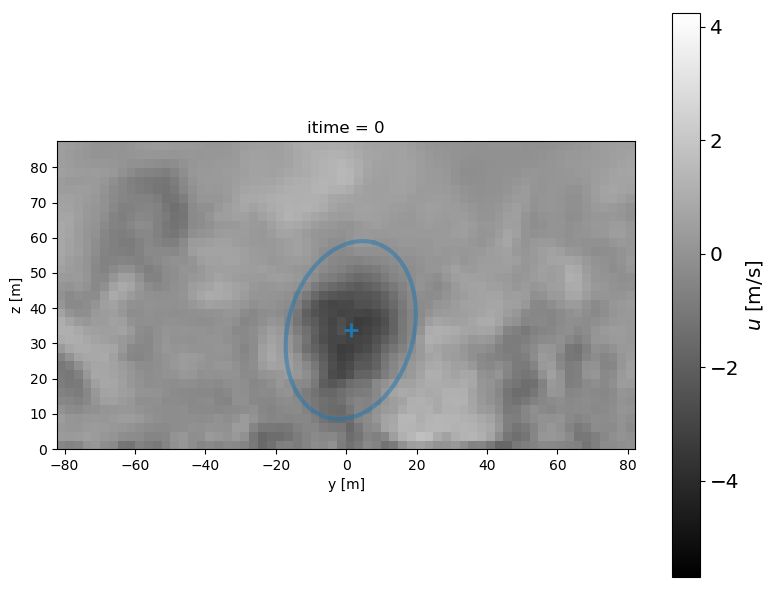

In [10]:
wplt = wo.plot()

In [11]:
%time wplt.animate('wakes_Gauss2D_defaults.mp4')

Plot: frame 792

CPU times: user 43.9 s, sys: 1.67 s, total: 45.5 s
Wall time: 45.7 s


Plot: frame 793

## check trajectory

In [12]:
from trajectory import Trajectory

In [13]:
traj = Trajectory(case,'2D-Gaussian_fit')

WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/2D-Gaussian_fit/trajectory_3D.csv


In [14]:
def moving_median(series, window):
    return series.rolling(window, center=True).median()

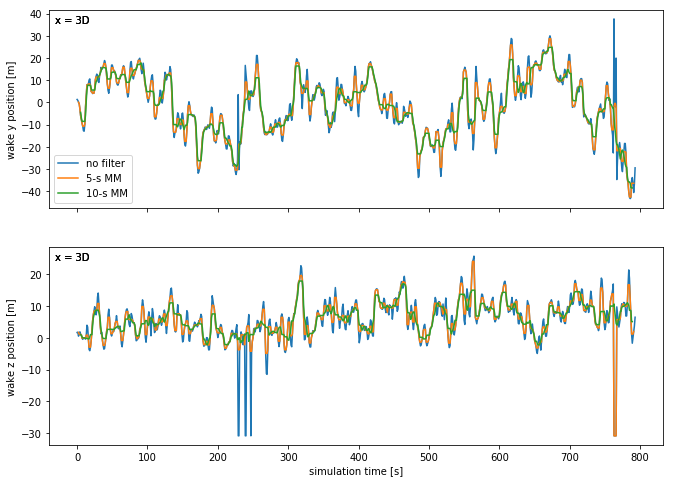

In [15]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
traj.plot_wake_hist('y',fig=fig,ax=ax[0],label='no filter')
traj.plot_wake_hist('z',fig=fig,ax=ax[1])
traj.plot_wake_hist('y',fig=fig,ax=ax[0],applyfilter=lambda hist: moving_median(hist,5),label='5-s MM')
traj.plot_wake_hist('z',fig=fig,ax=ax[1],applyfilter=lambda hist: moving_median(hist,5))
traj.plot_wake_hist('y',fig=fig,ax=ax[0],applyfilter=lambda hist: moving_median(hist,10),label='10-s MM')
traj.plot_wake_hist('z',fig=fig,ax=ax[1],applyfilter=lambda hist: moving_median(hist,10))
ax[0].set_ylabel('wake y position [m]')
ax[1].set_ylabel('wake z position [m]')
ax[-1].set_xlabel('simulation time [s]')
#ax[0].legend(loc='upper left',bbox_to_anchor=(1.05,1))
ax[0].legend(loc='best')